## Metabolic brain image analysis in the StateViewer framework
This tutorial will review the analysis of metabolic (that is fluorodeoxyglucose positron emission tomography, FDG-PET) brain imaging within the framework of StateViewer, a clinical decision support tool for assisting in the diagnosis of neurodegenerative diseases [1]. This tutorial will utilize a set of **synthetic** (read: not real) but fairly realistic FDG-PET brain images that approximate the features found across a wide spectrum of clinical neurodegenerative diagnoses:
* Alzheimer's disease (ad)
* Behavioral variant frontotemporal dementia (bvftd)
* Corticobasal syndrome (cbs)
* Dementia with Lewy bodies (dlb)
* Logopenic variange primary progressive aphasia (lvppa)
* Nonfluent primary progressive aphasia (nfppa)
* Posterior cortical atrophy (pca)
* Semantic dementia (sd)
* Progressive supranuclear palsy (psp)

Examples representing cases with no known neurodegeneration (cognitively unimpaired, cu) are also provided. All images have been registered to the MCALT template space [2]. 

We will start by installing a few dependencies, as well as the python library `svlite`, which provides the core data types and funtions used in the StateViewer analyses. 

In [1]:
!pip install nibabel --quiet
!pip install nilearn --quiet
!pip install antspyx --quiet
!pip install seaborn==0.13.2 --quiet
!pip install git+https://github.com/Neurology-AI-Program/svlite.git --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.6.4 requires numpy<1.26,>=1.16.0, but you have numpy 1.26.4 which is incompatible.
ydata-profiling 4.6.4 requires seaborn<0.13,>=0.10.1, but you have seaborn 0.13.2 which is incompatible.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.lines import Line2D
from joblib import Parallel, delayed
import seaborn as sns
import ants
from typing import Callable
from functools import partial

import nilearn.image
import nilearn.plotting
import nilearn.datasets
import nilearn.surface
import nibabel

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, auc, roc_curve

from svlite.data_structures import BrainTable, AnnotationTable, VectorTable
from svlite.transformer import VectorTransformer
from svlite.graphical import KNeighbors, BrainGraph, score_holdout, report_metrics, get_calls

### Data set description
The provided data includes a total of 1500 synthetic FDG-PET NiFTI1 image files split into 3 groups called the zscore set, the pca set, and the model set, the meaning of which will become clear later. Each set of images also has a corresponding csv file containing diagnostic catagories represented by each image. A few image files necessary for processing and aanalysis are also provided.

Let's begin by locating the data and plotting one of the images using `nilearn`.

In [3]:
#Data is available to the kernel in this location, if running locally change this path to the location where you have saved the data
data_root = '/kaggle/input/synthetic-neurodegenerative-brain-image-data-set' 

In [4]:
#Here is the directory structure
! ls /kaggle/input/synthetic-neurodegenerative-brain-image-data-set/

brain_mask.nii	model_annotations.csv  pca_set		       zscore_set
mcalt_t1.nii	model_set	       pons_mask.nii
mni_t1.nii	pca_annotations.csv    zscore_annotations.csv


In [5]:
#CSV files corresponding to the three sets of images
zscore_csv_path = f'{data_root}/zscore_annotations.csv'
pca_csv_path = f'{data_root}/pca_annotations.csv'
model_csv_path = f'{data_root}/model_annotations.csv'

#Create one dataframe per set of images
zscore_df = pd.read_csv(zscore_csv_path, index_col = 0)
pca_df = pd.read_csv(pca_csv_path, index_col = 0)
model_df = pd.read_csv(model_csv_path, index_col = 0)

In [6]:
#The index values of each dataframe correspond to image file paths. Let's take one value and load the image:
model_df.head()

,subject,scan_date,label,ad,bvftd,cbs,cu,dlb,lvppa,nfppa,pca,psp,sd
uid,,,,,,,,,,,,,
sub-ltkn-257_ses-20170401_66,ltkn-257,2017-04-01,cbs,0,0,1,0,0,0,0,0,0,0
sub-zqvx-328_ses-20131103_88,zqvx-328,2013-11-03,cu,0,0,0,1,0,0,0,0,0,0
sub-obnk-370_ses-20090517_49,obnk-370,2009-05-17,cu,0,0,0,1,0,0,0,0,0,0
sub-visg-800_ses-20110818_54,visg-800,2011-08-18,lvppa,0,0,0,0,0,1,0,0,0,0
sub-srtr-878_ses-20131206_11,srtr-878,2013-12-06,sd,0,0,0,0,0,0,0,0,0,1


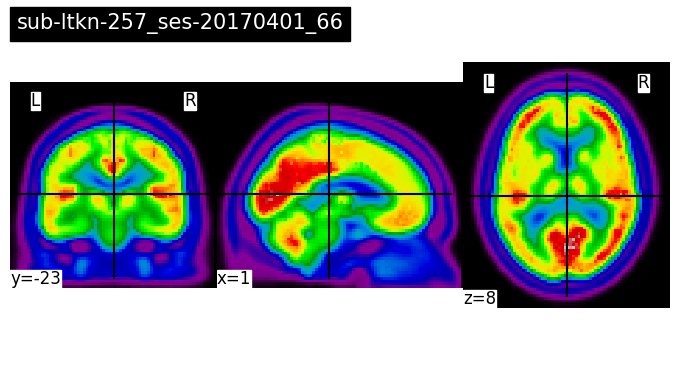

In [8]:
#Given an index value and image set name, we can locate the corresponding image with the pattern {data_root}/{image_set}/{image_set}/{index_value}.nii
test_uid = 'sub-ltkn-257_ses-20170401_66'
test_img = nilearn.image.load_img(f'{data_root}/model_set/model_set/{test_uid}.nii')
nilearn.plotting.plot_img(test_img, title = test_uid, cmap = 'nipy_spectral')

### BrainTable construction
We will analyze these sets of images using a data structure from `svlite` called a `BrainTable`. This is essentially a DataFrame where one of the columns contains a flattened 1D array of the voxel values from a specified region of interest for each image (in our case the brain). We specify this region using a mask image, which is provided in the file `brain_mask.nii`:

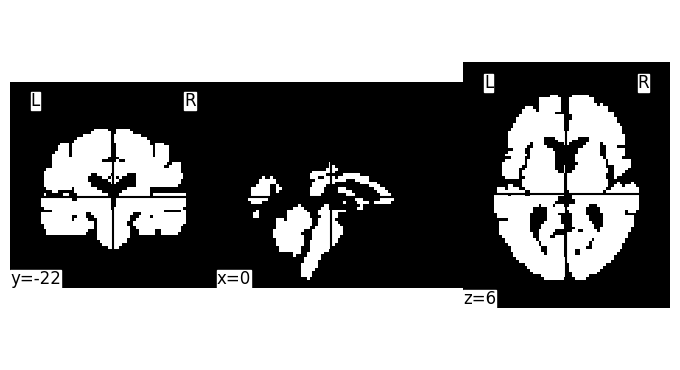

In [9]:
brain_mask = nilearn.image.load_img(f'{data_root}/brain_mask.nii')
nilearn.plotting.plot_img(brain_mask, cmap = 'bone')

Constructing a BrainTable typically involves the following items:

* `brain_mask`: A brain mask used to specify which voxels to include in the image, 
* `suvr_mask`: (optional) A mask specifying the region used for standardized uptake value ratio (SUVR) normalization. This is a straightforward normalization procedure where the voxel intensities of the image are divided by the median intensity value of some reference region. For FDG-PET it is conventional to use the pons as the SUVR reference region, and the file `pons_mask.nii` contains a mask for this purpose.
* `df`: A DataFrame, like the ones we defined above, the rows of which each correspond to a single image.
* `img_loader`: A user defined function that takes a row from the DataFrame and returns a tuple of the form `(img_identifier: str, img: nibabel.NiNifti1Image)`

Some additional optional arguments (e.g. for resampling or smoothing) are described in the `BrainTable` creation step below.

We will begin by defining the `img_loader`. Let's create a simple image loader function that will load images from the model set:

In [19]:
def base_img_loader(image_root: str, row: tuple[str,pd.Series]) -> tuple[str, nibabel.Nifti1Image]:
    
    return row[0], nilearn.image.load_img(f'{image_root}/{row[0]}.nii')

#We will create a partially parameterized copy of the base_img_loader using partial (type hints used here to make it more clear)
test_img_loader: Callable[[tuple[str, pd.Series]], tuple[str, nibabel.Nifti1Image]] = partial(base_img_loader, f'{data_root}/model_set/model_set')

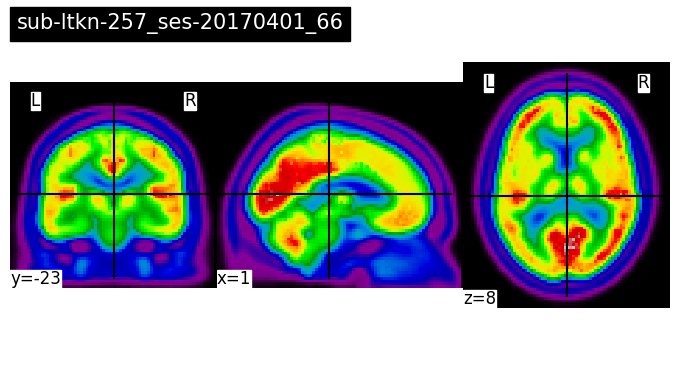

In [20]:
arow = next(iter(model_df.iterrows()))
img_identifier, test_img_from_loader = test_img_loader(arow)
nilearn.plotting.plot_img(test_img_from_loader, title = img_identifier, cmap = 'nipy_spectral')

In [22]:
#To avoid mistakes, we will define img_loader functions parameterized by the image root paths for each set:
zscore_img_loader: Callable[[tuple[str, pd.Series]], tuple[str, nibabel.Nifti1Image]] = partial(base_img_loader, f'{data_root}/zscore_set/zscore_set')
pca_img_loader: Callable[[tuple[str, pd.Series]], tuple[str, nibabel.Nifti1Image]] = partial(base_img_loader, f'{data_root}/pca_set/pca_set/')
model_img_loader: Callable[[tuple[str, pd.Series]], tuple[str, nibabel.Nifti1Image]] = partial(base_img_loader, f'{data_root}/model_set/model_set/')

Next, we will create a `BrainTable` corresponding to each image set. Roughly, this process iterates over each row of the provided `DataFrame` and applies the following logic:
* Load the image with the image loader function
* Optionally resample the image to a new resolution, if specified
* Optionally smooth the image using a gaussian kernel, if specified
* Optionally normalize the image using the SUVR mask image, if specified
* Mask the image using the provided brain mask image
* Flatten the remaining voxel values into a 1D array
* Store the 1D array in a column of the output table

On the Kaggle kernel, creating all 3 `BrainTables` will take a couple minutes

In [15]:
#Load the mask image used for SUVR normalization
suvr_mask = nilearn.image.load_img(f'{data_root}/pons_mask.nii')

#Construct the BrainTables for each of the 3 image sets. We will resample each image to voxel size of 3 mm square, and smooth each image using a 4 mm kernel.
B_zs_suvr = BrainTable(
    df = zscore_df, #DataFrame corresponding to the set of images
    img_loader = zscore_img_loader, #Function used to load the image corresponding to each row of df
    brain_mask = brain_mask, #Mask image specifying the region to be included in the brain table
    suvr_mask = suvr_mask, #Optionally, mask image specifying the region to be used for SUVR. If not provided, the images are not normalized
    subject_col = 'subject', #Optionally, the field in df that identifies the subject of the image
    incident_date_col = 'scan_date', #Optionally, the field in the df that specifies the date of the image
    resample_affine = 3*np.eye(3), #Optionally, a diagonal matrix containing the desired output voxel size in mm in each dimension
    smoothing_fwhm = 4 #Optionally, the size in mm of the gaussian kernel fwhm to be used to smooth the image
)

B_pca_suvr = BrainTable(
    df = pca_df,
    img_loader = pca_img_loader,
    brain_mask = brain_mask,
    suvr_mask = suvr_mask,
    subject_col = 'subject',
    incident_date_col = 'scan_date',
    resample_affine = 3*np.eye(3),
    smoothing_fwhm = 4
)

B_model_suvr = BrainTable(
    df = model_df,
    img_loader = model_img_loader,
    brain_mask = brain_mask,
    suvr_mask = suvr_mask,
    subject_col = 'subject',
    incident_date_col = 'scan_date',
    resample_affine = 3*np.eye(3),
    smoothing_fwhm = 4
)

The content of a `BrainTable` is contained in the `data` attribute, which is a `pd.DataFrame`:

In [14]:
B_model_suvr.data.head()

,subject,scan_date,label,ad,bvftd,cbs,cu,dlb,lvppa,nfppa,pca,psp,sd,image_vector
uid,,,,,,,,,,,,,,
sub-ltkn-257_ses-20170401_66,ltkn-257,2017-04-01,cbs,0,0,1,0,0,0,0,0,0,0,"[0.9518607429593472, 1.0286754627734627, 1.023..."
sub-zqvx-328_ses-20131103_88,zqvx-328,2013-11-03,cu,0,0,0,1,0,0,0,0,0,0,"[0.9807978322155578, 1.0665351082481127, 1.058..."
sub-obnk-370_ses-20090517_49,obnk-370,2009-05-17,cu,0,0,0,1,0,0,0,0,0,0,"[0.9904985927979896, 1.0710921298487757, 1.068..."
sub-visg-800_ses-20110818_54,visg-800,2011-08-18,lvppa,0,0,0,0,0,1,0,0,0,0,"[0.8595372894457837, 0.90258845109294, 0.90884..."
sub-srtr-878_ses-20131206_11,srtr-878,2013-12-06,sd,0,0,0,0,0,0,0,0,0,1,"[0.9264346712439764, 0.9658960369018272, 0.993..."


This `data` attribute contains all of the same information as the input `DataFrame` but also contains the image content as a vector in the new `image_vector` column.

We can reconstruct the image for any particular row in the `BrainTable` using the `vector_to_brain()` method and providing the index of the desired row. We will use the same test_uid we used above:

In [24]:
test_img_from_bt = B_model_suvr.vector_to_brain(label = test_uid)

This image is the same as the one that we viewed above, except that it has been resampled, smoothed, and masked to include only the brain. To see this, let's overlay it on the template space structural MRI image (also provided):


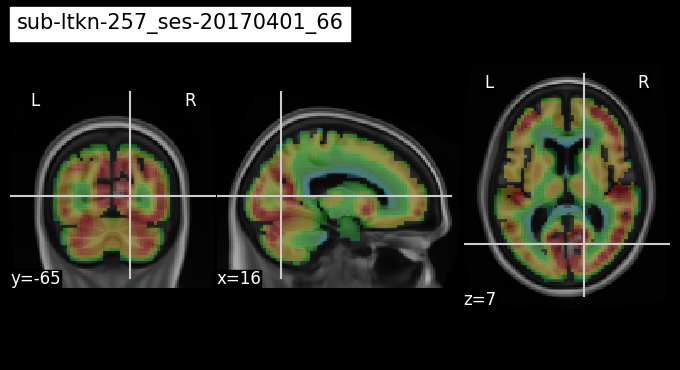

In [25]:
mcalt_t1 = nilearn.image.load_img(f'{data_root}/mcalt_t1.nii')
nilearn.plotting.plot_img(test_img_from_bt, title = test_uid, bg_img = mcalt_t1, alpha = 0.3, cmap = 'nipy_spectral', black_bg = True)

### Image standard scaling
Up until now we have been viewing these images in raw intensity units or SUVR normalized intensity units, but it is usually more useful to view metabolism in reference to some normative value. We will do this by standard scaling our images using the zscore image set (that is, by computing the mean and standard deviation of voxel values in the zscore set, and then standardizing the images in the other sets by subtracting the zscore set mean and dividing by the zscore standard deviation). The zscore set of images contains 500 representatives of the cognitively unimpaired or cu pattern. This way, the standard scaled voxel values will have the meaning of "relative metabolism compared to normal, nondegenerative tissue."

Rather than do this ourselves, we will use the convenient `scikit-learn` `StandardScaler` class to do it for us. This is accomplished by wrapping an instance of the `StandardScaler` in the `VectorTransformer` class from `svlite`. This class takes any `scikit-learn` class that has `fit()` and `transform()` methods and allows it to be applied to the `BrainTable` class.

In [26]:
#Initialize the scikit learn transformer
scaler_base_model = StandardScaler()

#Initialize the scaling VectorTransformer with the base scikit learn object
scaler_tf = VectorTransformer(scaler_base_model)

#Fit the scaling VectorTransformer using the zscore 
scaler_tf.fit(B_zs_suvr)

#Apply the scaling VectorTransformer to the BrainTables of the pca and model image sets
B_pca_scaled = scaler_tf.transform(B_pca_suvr)
B_model_scaled = scaler_tf.transform(B_model_suvr)

Because the output of the scaler `transform()` method is still a `BrainTable`, we can reconstruct the image just as we did before. Now we can see that there are both positive and negative voxel values, indicating where the metabolism is high or low relative to the standard reference.

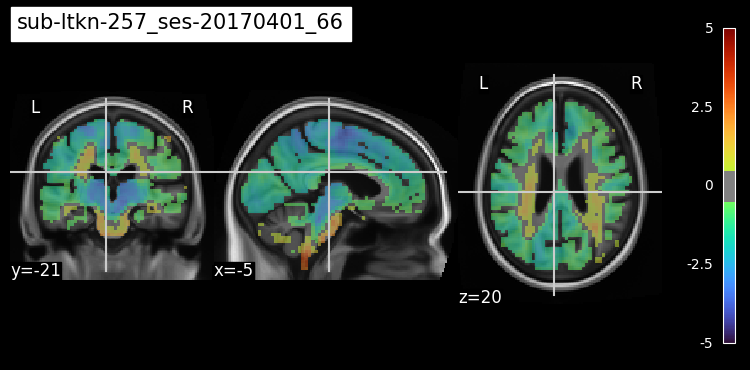

In [27]:
scaled_img_from_bt = B_model_scaled.vector_to_brain(label = test_uid)
nilearn.plotting.plot_img(scaled_img_from_bt, title = test_uid, bg_img = mcalt_t1, alpha = 0.5, cmap = 'turbo', vmin = -5, vmax = 5, threshold = 0.5, black_bg = True, colorbar = True)

### Cortical surface projection
Before proceeding with the StateViewer analysis, we will go through one last preliminary component on visualization. So far, we have viewed the image in a standard orthographic view through 3 slices, but it is also helpful to visualize FDG-PET as a surface projection onto a 3D model of the cortical surface. `nilearn` has very helpful functions for this. Because we don't have a mesh handy that corresponds to our MCALT template, we will write a function that transforms our images onto the MNI template so that we can utilize the built in mesh in `nilearn`.

First, we will use `ants` to establish a transformation that brings us from MCALT to MNI using the MCALT and MNI MRI images.

In [28]:
mni_t1 = nilearn.image.load_img(f'{data_root}/mni_t1.nii')
mni_t1_ants = ants.from_nibabel(mni_t1)
mcalt_t1_ants = ants.from_nibabel(mcalt_t1)
mcalt_to_mni = ants.registration(mni_t1_ants, mcalt_t1_ants)

Next, we will write a function that uses this transformation and applies it to any input image:

In [30]:
def template_space_transform(mni_t1: nibabel.Nifti1Image, transform_list: list, img: nibabel.Nifti1Image):
    
    mni_ti_ants = ants.from_nibabel(mni_t1)
    img_ants = ants.from_nibabel(img)
    img_ants_tf = ants.apply_transforms(mni_t1_ants, img_ants, transform_list)
    img_tf = ants.to_nibabel(img_ants_tf)
    
    return img_tf

#We will again create a partially parameterized function so that in future we only need to specify the image we want to transform
mni_transform: Callable[[nibabel.Nifti1Image], nibabel.Nifti1Image] = partial(template_space_transform, mni_t1, mcalt_to_mni['fwdtransforms'])

We can check to see if it worked by displaying the MNI transformed image using the MNI structural image as background.

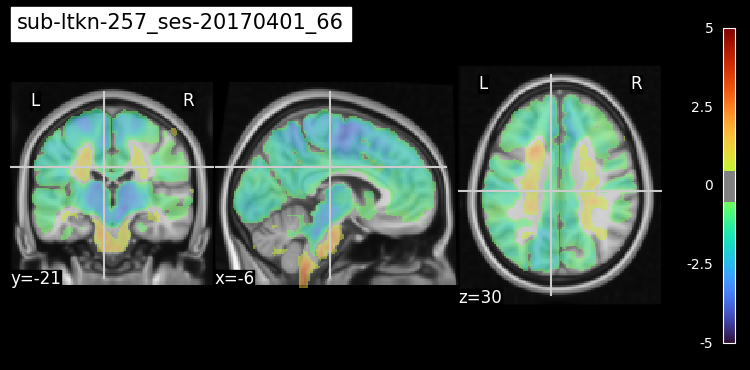

In [31]:
scaled_img_mni = mni_transform(scaled_img_from_bt)
nilearn.plotting.plot_img(scaled_img_mni , title = test_uid, bg_img = mni_t1, alpha = 0.5, cmap = 'turbo', vmin = -5, vmax = 5, threshold = 0.5, black_bg = True, colorbar = True)

Now that we have the image on an appropriate template, we can use the built-in `nilearn` FreeSurfer average assets to view the image as a projection on the cortical surface:

(<Figure size 426.667x480 with 5 Axes>,
 [<Axes3D: >, <Axes3D: >, <Axes3D: >, <Axes3D: >, <Axes: >])

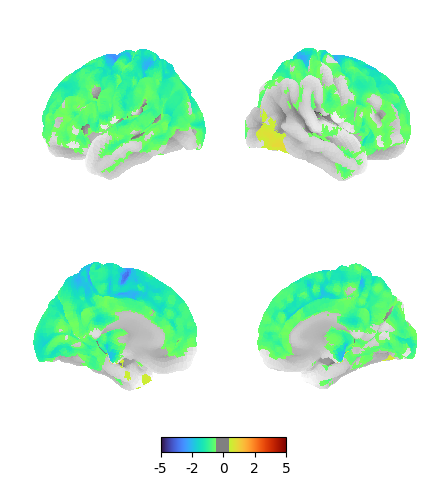

In [32]:
nilearn.plotting.plot_img_on_surf(
    stat_map = scaled_img_mni,
    threshold = 0.5,
    vmax = 5,
    cmap = 'turbo'
)

### StateViewer model
The StateViewer model itself is straightforward, it consists of a k-nearest neighbors model based on cosine similarity in a latent space defined by principal component decomposition of the vectorized brain images. We will start by fitting the PCA model using the standard scaled PCA set BrainTable

In [56]:
#Initialize the base sklearn PCA model:
pca_base_model = PCA(n_components = 30, whiten = True, svd_solver = 'full')

#Initialze the BrainTable transformer with the base model
pca_tf = VectorTransformer(pca_base_model)

#Fit the BrainTable transformer using the scaled PCA set BrainTable
pca_tf.fit(B_pca_scaled)

#Apply the BrainTable transformer to the scaled model set BrainTable to generate the PCA features
model_features = pca_tf.transform(B_model_scaled)

The output of the `pca_tf.transform()` method is no longer a `BrainTable`, as it has undergone dimensionality reduction, but is instead a more generic data type called a `VectorTable`, which shares many of the aspects of the `BrainTable` except those related specifically to brain imaging tasks such as `vector_to_brain()`.

In [57]:
model_features.data.head()

,subject,scan_date,label,ad,bvftd,cbs,cu,dlb,lvppa,nfppa,pca,psp,sd,image_vector
uid,,,,,,,,,,,,,,
sub-ltkn-257_ses-20170401_66,ltkn-257,2017-04-01,cbs,0,0,1,0,0,0,0,0,0,0,"[-0.6136831874473049, -1.2239333304530047, 0.0..."
sub-zqvx-328_ses-20131103_88,zqvx-328,2013-11-03,cu,0,0,0,1,0,0,0,0,0,0,"[0.34617960307000367, -0.8918369973126771, -0...."
sub-obnk-370_ses-20090517_49,obnk-370,2009-05-17,cu,0,0,0,1,0,0,0,0,0,0,"[1.7602178294430655, 0.7358261791562807, -0.29..."
sub-visg-800_ses-20110818_54,visg-800,2011-08-18,lvppa,0,0,0,0,0,1,0,0,0,0,"[-1.1757438141019498, 0.3850376208669998, -0.3..."
sub-srtr-878_ses-20131206_11,srtr-878,2013-12-06,sd,0,0,0,0,0,0,0,0,0,1,"[0.0698745577260843, 1.023570174276173, 1.5892..."


In addition to the PCA features for the model set, we will also want the annotations for the model set in the form of an `AnnotationTable`. This is a data structure that is designed for aligning annotations with the vectors found in the `VectorTable`.

In [58]:
#When creating an annotation table, all columns that are not designated as index, subject, or incident date columns, or included in the supplemental_cols
#will be automatically designated as either binary or continuous annotations.
model_annotations = AnnotationTable(
    data = model_csv_path, #path to csv file used for annotation table
    index_col = 'uid', #Column name to be used as the index 
    subject_col = 'subject', #Column containing subject identifier
    incident_date_col = 'scan_date', #Column containing image date
    supplemental_cols= ['label'] #Other columns that are to be kept on the table but ignored
)

The k-nearest neighbors model itself is implemented by the `KNeighbors` class from `svlite.graphical`. In contrast with the `NearestNeighbor` class provided by `scikit-learn`, this class provides a graphical interpretation of a k-nearest neighbors model and extends the `DiGraph` class from the `networkx` library. 

In [59]:
#Initialize the KNeighbors graph
knn = KNeighbors(n_neighbors = 16, metric = 'cosine')

#Populate the graph with nodes and edges baed on the model_features, and annotate the nodes with the model_annotations
knn.populate(model_features, model_annotations)

### Performance evaluation

In a conventional k-neighbors classifier, the inferred label is based on the highest fraction label among the k-neighbors. In the StateViewer framework, the k-neighbors model is used as a label detection tool, rather than a single target classifier, and the label fraction among neighbors is not used. Instead, for each label, the model uses the odds ratio of a 2x2 table where the margins are inside vs outside the neighborhood and with vs without the label. Results where the odds ratio is greater than 1 are considered "detections" for that label. In addition to the odds ratio, the model also uses the P value resulting from the Fisher exact test of the same 2x2 table, which is used as a measure of detection strength that is resilient to class imabalance. These metrics can be computed with the `neighbor_votes()` method. **Note, this method provides estimates for all nodes in the graph in leave-one-out fashion.**

In [60]:
odds = knn.neighbor_votes(metric = 'odds_ratio')
pvals = knn.neighbor_votes(metric = 'fisher', fisher_alternative = 'greater')

The overall separation of labels can be estimated by ROC curves using the odds ratio as the decision function:

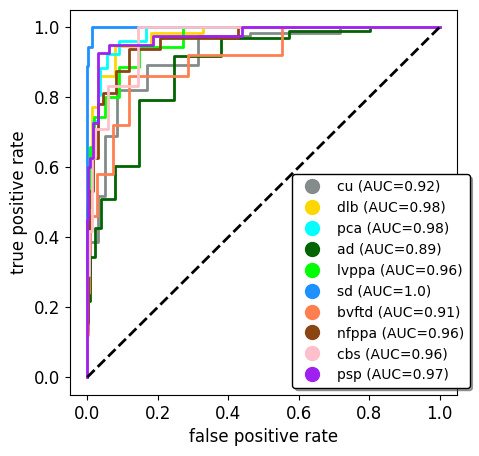

In [61]:
#We will define some constants for plotting scoring metrics:
plt.style.use('default')
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

node_color_map = {
    'ad' : "#006400",
    'bvftd' : "#FF7F50",
    'cbs' : 'pink',
    'cu' : "#838B8B",
    'dlb' : "#ffd700",
    'lvppa' : "#00ff00",
    'nfppa' : "#8B4513",
    'pca' : "#00ffff",
    'ppaos' : "#ff1493",
    'sd' : "#1e90ff",
    'psp' : "#a020f0",
    'total' : 'black'
}

col_order = ['cu', 'dlb', 'pca', 'ad', 'lvppa', 'sd', 'bvftd', 'nfppa', 'cbs', 'psp', 'total']
degen_cols = [c for c in col_order if c not in ['cu', 'total']]

fig, ax = plt.subplots(figsize = (5, 5))
handles = []
for pt in col_order[:-1]:
    fpr, tpr, _ = roc_curve(model_annotations.data[pt], odds[pt])
    score = auc(fpr, tpr)
    ax.plot(fpr, tpr, c = node_color_map[pt], lw = 2, ls = '-')
    handle = mlines.Line2D(
        [], [], 
        color = node_color_map[pt], 
        marker = 'o', 
        fillstyle = 'full', 
        label = f'{pt} (AUC={np.round(score, 2)})', 
        linestyle = "None",
        markersize = 10
    )
    handles.append(handle)

ax.plot([0, 1], [0, 1], ls = '--', c = 'black', lw = 2)
ax.set_xlabel('false positive rate')
ax.set_ylabel('true positive rate')
ax.legend(handles = handles, bbox_to_anchor=(1.05, 0.00), loc = 4, shadow = True, frameon = True, fontsize = 10, ncols = 1, edgecolor = 'black')

The odds ratios and P values can be combined to make "hard calls" or 0/1 inferences for each label. This is implemented using the `get_calls()` function from `svlite.graphical`, which requires the P value threshold that we consider significant, and the total number of calls we would like to allow for each case. A more liberal P value threshold provides higher sensitivity, while a more strict cutoff results in higher precision.

In [62]:
sens_calls = get_calls(knn, threshold = 1, top_n = 3)
prec_calls = get_calls(knn, threshold = 1E-2, top_n = 3)

In the sensitive calls, each image is generally given multiple detected labels, up to 3 as we specified with the `top_n` argument.

In [63]:
sens_calls.head()

,ad,bvftd,cbs,cu,dlb,lvppa,nfppa,pca,psp,sd
sub-ltkn-257_ses-20170401_66,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
sub-zqvx-328_ses-20131103_88,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
sub-obnk-370_ses-20090517_49,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
sub-visg-800_ses-20110818_54,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
sub-srtr-878_ses-20131206_11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In the more precise calls, each image is generally only given a single call or in some cases no calls at all.

In [64]:
prec_calls.head()

,ad,bvftd,cbs,cu,dlb,lvppa,nfppa,pca,psp,sd
sub-ltkn-257_ses-20170401_66,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sub-zqvx-328_ses-20131103_88,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
sub-obnk-370_ses-20090517_49,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sub-visg-800_ses-20110818_54,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
sub-srtr-878_ses-20131206_11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


We can estimate the performance of the model by these metrics by repeatedly resampling balanced hold out sets. This is implemented using the `score_holdout` function from `svlite.graphical` (on the Kaggle kernel this takes several minutes):

In [65]:
#We will evaluate model performance over a grid of P value thresholds
p_grid = [1, 0.1, 0.01, 0.001, 0.0001]

#We will estimate performance metrics over 100 resamplings
n_tasks = 100

#To make things go a little faster, we will define a task we can distribute over processor cores using Parallel:
task = lambda graph, p, n: score_holdout(graph, n_per_class = n, top_n = 3, threshold = p)

#For each measurement, we will randomly sample the parameter n_per_class from the range 5-15.
holdout_metrics = {p : Parallel(n_jobs = 10)(delayed(task)(knn, p, np.random.choice(np.arange(5, 16))) for _ in range(n_tasks)) for p in p_grid}

The `score_holdout` function returns scores in the form of a nested dictionary, so we will define a simple function to parse these into a dictionary:

In [66]:
def form_metric_dfs(holdout_scores: list[dict], metrics: list[str]) -> pd.DataFrame:
    
    rows = []
    for p in holdout_scores:
        for m in metrics:
            vals = holdout_scores[p]
            for val in vals:
                row = {'metric' : m, 'pvalue_threshold' : p}
                for pt in val:
                    if m in val[pt]:
                        row[pt] = val[pt][m]
                rows.append(row)
                
    return pd.DataFrame(rows)

In [67]:
sens_prec_df = form_metric_dfs(holdout_metrics, ['sens', 'prec'])
sens_data = pd.melt(sens_prec_df.query(f'(pvalue_threshold == 1.0) & (metric == "sens")'), value_vars = col_order)
prec_data = pd.melt(sens_prec_df.query(f'metric == "prec"'), id_vars = ['pvalue_threshold'], value_vars = col_order)
prec_data['nlogp'] = -np.log10(prec_data['pvalue_threshold'])

#### Sensitivity
The proposed workflow for StateViewer is to first detect the most plausible labels without applying any P value threshold, and then to measure precision as a function of P value threshold in order to calibrate the strength of any detection in terms of false positive rate. 

First, let's plot sensitivity for each class:

[Text(0.5, 0, '')]

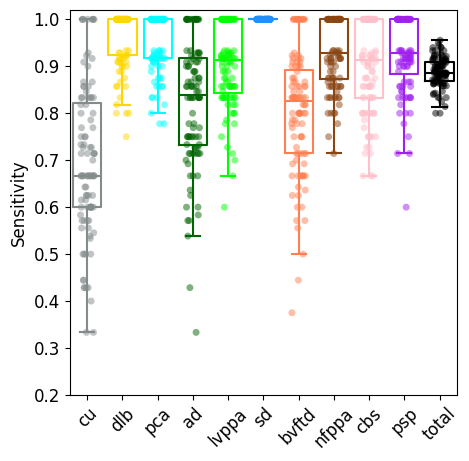

In [68]:
fig, ax_sens = plt.subplots(figsize = (5, 5))

sns.boxplot(data = sens_data, x = 'variable', y = 'value', hue = 'variable', color = '.9', ax = ax_sens, showfliers=False, palette = [node_color_map[c] for c in col_order], fill = False)
sns.stripplot(data = sens_data, x = 'variable', y = 'value', hue = 'variable', ax = ax_sens, size = 5, alpha = 0.5, jitter = 0.2, palette = [node_color_map[c] for c in col_order])
ax_sens.set_ylim([0.1, 1.02])
ax_sens.set_ylabel('Sensitivity')
ax_sens.tick_params(axis = 'x', rotation = 45)
ax_sens.set_ylim([0.2, 1.02])
ax_sens.set(xlabel = None)


#### Precision
We are interested in precision as a function of P value threshold, so that we can estimate the precision of any particular detection based on the P value.


/tmp/ipykernel_33/2434011369.py:42: UserWarning:

FixedFormatter should only be used together with FixedLocator

/tmp/ipykernel_33/2434011369.py:42: UserWarning:

FixedFormatter should only be used together with FixedLocator

/tmp/ipykernel_33/2434011369.py:42: UserWarning:

FixedFormatter should only be used together with FixedLocator



Text(0.5, -0.01, 'P value threshold')

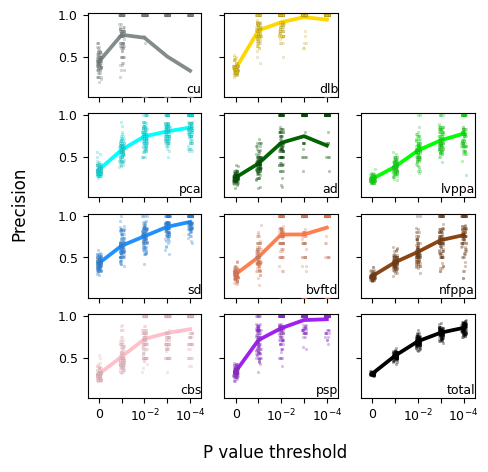

In [69]:

prec_fig_order = [c for c in col_order]
prec_fig_order.insert(2, 'blank')

fig, axes = plt.subplots(nrows = 4, ncols = 3, figsize = (5,5))
axes = axes.flatten()
for i, (p, ax) in enumerate(zip(prec_fig_order, axes)):
    if p == 'blank':
        ax.set_axis_off()
    else:
        sns.stripplot(
            data = prec_data.query(f'variable == "{p}"'), 
            x = 'nlogp', 
            y = 'value', 
            legend = False, 
            color = node_color_map[p],
            size = 2,
            alpha = 0.3,
            linewidth = 0.2,
            ax = ax
        )

        sns.pointplot(
            data = prec_data.query(f'variable == "{p}"'), 
            x = 'nlogp', 
            y = 'value', 
            legend = False, 
            color = node_color_map[p],
            ax = ax,
            errorbar = None,
            markers = None,
            alpha = 1,
            capsize = 0.05,
            err_kws={'linewidth': 1.5}
        )

        if i%3 != 0:
            ax.set_yticklabels([])
        
        if i < 9:
            ax.set_xticklabels([])
        else:
            ax.set_xticklabels([0, '', '$\mathregular{{10^{{-{2}}}}}$', '', '$\mathregular{{10^{{-{4}}}}}$'])

        ax.set(ylabel = None)
        ax.set(xlabel = None)
        ax.set_ylim([0.02, 1.02])
        ax.annotate(p, xy=(4.5, 0.05), xycoords=ax.get_xaxis_transform(), size = 9, ha = 'right')
        ax.tick_params(axis='both', which='major', labelsize=9)

fig.text(-0.03, 0.5, 'Precision', va='center', rotation='vertical', fontsize = 12)
fig.text(0.5, -0.01, 'P value threshold', ha='center', fontsize = 12)


#### Discovery rate
Because StateViewer is based on clinical diagnoses, which often have complex and overlapping relationships with underlying etiologies, it is often of interest to examine alternative explanations for model detections. We quantify this using the discovery rate metric for each pair of labels *i,j*, which measures the rate at which detections of label *i* correspond to true observations of label *j*. The case where *i=j* corresponds to the precision score for label *i*, and the sum over labels *j!=i* corresponds to the false discovery rate for label *i*. 

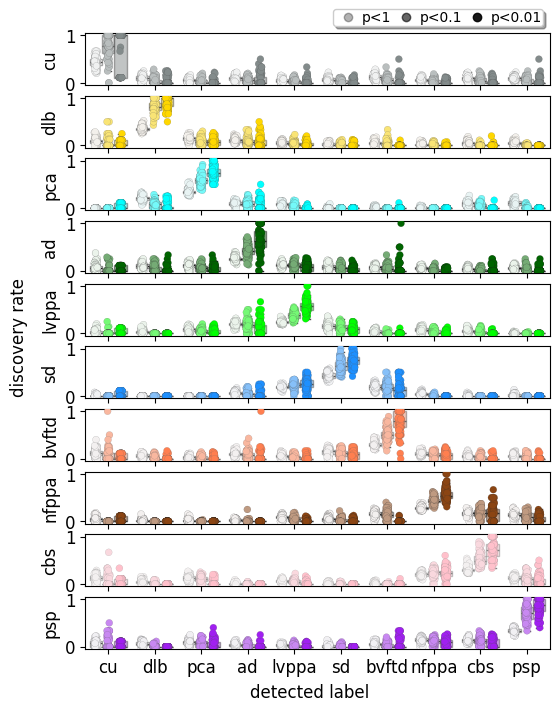

In [70]:
pairwise_metrics = [f'{pt}_adr' for pt in col_order[:-1]]
adr_df = form_metric_dfs(holdout_metrics, pairwise_metrics)
pvals = [0.01, 0.1, 1]
pt_order = col_order[:-1]

fig, axes = plt.subplots(nrows = len(pt_order), figsize = (6, 8))
for ax, pt in zip(axes, pt_order):
    melted = pd.melt(adr_df.reset_index(), id_vars = ['metric', 'pvalue_threshold'], value_vars = pt_order)\
        .query(f'pvalue_threshold in {pvals}', engine = 'python')\
        .query(f'metric == "{pt}_adr"')

    melted['nlogp'] = -np.log10(melted['pvalue_threshold'])

    sns.stripplot(
        melted, 
        x = 'variable', 
        y = 'value', 
        hue = 'nlogp', 
        dodge = True, 
        ax = ax, 
        legend = False, 
        palette = f'light:{node_color_map[pt]}',
        hue_order = pvals,
        linewidth = 0.1
        )

    sns.boxplot(
        melted, 
        x = 'variable', 
        y = 'value', 
        hue = 'nlogp', 
        ax = ax, 
        legend = False, 
        palette = f'light:{node_color_map[pt]}',
        hue_order = pvals,
        boxprops=dict(alpha=.5),
        showfliers=False
        )
    
    ax.set_ylabel(pt)
    ax.set_xlabel('')
    
fig.text(-0, 0.5, 'discovery rate', va='center', rotation='vertical', fontsize = 12)
fig.text(0.5, 0.05, 'detected label', ha='center', fontsize = 12)

legend_elements = [
    Line2D([0], [0], color='black', ls = '', marker = 'o', label='p<1', alpha = 0.3),
    Line2D([0], [0], color='black', ls = '', marker = 'o', label='p<0.1', alpha = 0.6),
    Line2D([0], [0], color='black', ls = '', marker = 'o', label='p<0.01', alpha = 0.9)
]

fig.legend(handles = legend_elements, bbox_to_anchor=(0.9, 0.88), loc = 4, shadow = True, frameon = True, fontsize = 10, ncol = 3, borderpad = 0.1, handletextpad = -0.05, columnspacing = 0.1)

### Feature importance
The most salient image features a given label can be visualized in StateViewer as a projection of the geometric median of that label from the PCA space back into the image space. The `calc_group_centers()` method of the model features `VectorTable` can be used to measure the geometric median vector for each label. 

In [71]:
#Construct groups of image IDs for each phentotype label
label_groups = [model_annotations.data.query(f'{pt} == 1').index.values for pt in pt_order]

#Compute geometric median vectors for each group
median_pca = model_features.calc_group_centers(label_groups, metric = 'cosine', group_names = pt_order)

#Extract projection matrix from PCA model
gamma = pca_base_model.components_\
    *np.sqrt(pca_base_model.n_samples_)\
    /pca_base_model.singular_values_.reshape(-1, 1)

#Project median vectors into image space
median_img = median_pca[0].to_numpy()@gamma

As an example, we can visualize the feature importance for the Alzheimer's Disease (AD) class:

(<Figure size 426.667x480 with 5 Axes>,
 [<Axes3D: >, <Axes3D: >, <Axes3D: >, <Axes3D: >, <Axes: >])

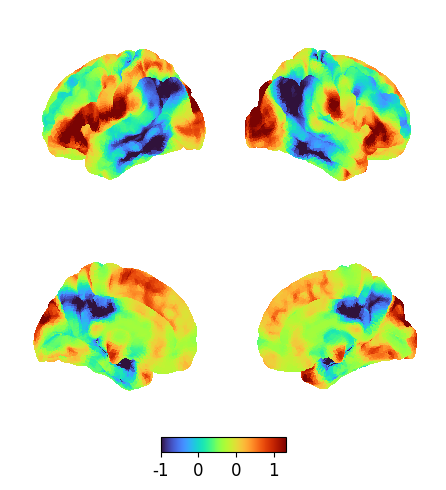

In [81]:
#Specify our phenotype of interest
pt = 'ad'
pt_index = np.argwhere(np.array(pt_order) == pt).flatten()[0]

#Select the image vector corresponding to the phenotype
pt_vector = median_img[pt_index, :]

#For plotting purposes, it is useful to standardize the voxel values
pt_vector = pt_vector/pt_vector.std()

#Convert the image vector into a Nifti1Image with the vector_to_brain method
pt_img = B_model_scaled.vector_to_brain(vec = pt_vector)

#Transform the phenotype image into MNI space
pt_img_mni = mni_transform(pt_img)

#Estimate the surface maximum value for display as the mean of the absolute values of the 5th and 95h percentiles
surf_max = np.abs(np.quantile(pt_vector, [0.05, 0.95])).mean()

#Plot the resulting image surface projection
nilearn.plotting.plot_img_on_surf(
    stat_map = pt_img_mni,
    vmax = surf_max,
    threshold = 0,
    cmap = 'turbo'
)

In the map for each, low/negative values indicate regions where the label is associated withrelative hypometabolism or degeneration, and high/positive values indicate regions where it is associated with relative hypermetabolism or sparing.